<a href="https://colab.research.google.com/github/karabash/2018webutvecklinglab3/blob/master/Inl%C3%A4mning_Laboration3_del2_klassificering_VT21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboration 3 del 2 klassificiering

In [ ]:
pip install missingno
#https://coderzcolumn.com/tutorials/data-science/missingno-visualize-missing-data-in-python

SyntaxError: ignored

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
import missingno as msno

In [ ]:
from google.colab import drive
try:
    from google.colab import drive
    drive.mount("/content/drive/", force_remount=True)
    google_drive_prefix = "/content/drive/My Drive"
    data_prefix = "{}/mnist/".format(google_drive_prefix)
except ModuleNotFoundError: 
    data_prefix = "data/"
drive.mount('/content/drive')

Mounted at /content/drive/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/lab3')
!pwd

/content/drive/MyDrive/lab3


In [ ]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

## Klassificering

I denna andra del ska ni testa att klassificera ett annat dataset med hjälp av två olika modeller för klassificering, logistiskt regression och desicion trees (som klarar såväl regression som klassificering). Vi kommer använda ett dataset som har data om överlevare från Titanic.

Det dataset vi ska använda finns i datamappen på GitHub och heter Titanic. Några av de bibliotek ni behöver för att komma igång är också importerade i nedan kod. 

Den del av laboration som handlar om decision trees är inspirerad av David Johnsson på Uppsala universitet.


### Logistisk regression för att bestämma om man överlever eller inte

De frågor som ska besvaras är märkta med **Q** medan coduppgifter är märkta med **C**.

I vissa fall finns flera delfrågor som kan innehålla både rena koduppgifter, frågor eller en kombination, dessa är märkta **QC**. Delfrågorna Dessa är i en lista med en bokstav framför, ex. a. Huruvida en deluppgift ska kodas eller enbart besvaras avgörs av er baserat på själva texten. När ni arbetar med uppgiften förväntas ni själva avgöra hur många kodblock som krävs för att kunna utföra uppgiften samt göra den tydlig och lätt att förstå. Samma sak gäller när ni kommenterar och besvarar frågor, skriv kortfattat men tydligt. **(OBS! Vissa uppgifter kräver flera kodblock, då behöver ni skapa dem!)**

**Exempel:**

**QC** Undersök hur många som levde och hur många som dog.

>a. Antal som överlevde och antal som dog?
>
>b. Hur många % överlevde?
>
>c. Visualisera antal överlevare och antal döda i ett stapeldiagram

In [368]:
train = pd.read_csv("/content/drive/MyDrive/lab3/titanic-train.csv", encoding="utf-8", sep=',')





<h3>Q Nedan är en översikt över några kolumner - fyll i vad varje kolumn står för där information saknas</h3>
<ol>
<li> `survival` - data type är int64 - 0 representeras vemsom dog och 1 representerar vem som överlevd </li>
<li> `pclass` - typ av biljetter (de sepereras 3 klasser)</li>
<li> `sex` - kön - string datatype</li>
<li> `age`- missing almost 20% </li>
<li> `sibsp` - # av syskon/äkta hälft ombord </li>
<li> `parch` - # av föräldrar/barn ombord </li>
<li> `ticket` - biljet nummer och data typen är string  </li>
<li> `fare` - data type är int och det representerar pris </li>
<li> `cabin` - missing over 77% - cabin nummer datatypen är string/objekt</li>
<li> `embarked` - missing 2%

Hamn där man steg ombord (C = Cherbourg, Q = Queenstown, S = Southampton)</li>
</ol> 


<h3>Koden</h3>
<p> Kolla gärna på frågan Vilka kolumner har nullvärden? för att se <strong>coden</strong> Elin 😊</p>



In [369]:

#yellow lines represent nan values 
#sb.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="viridis")
#plt.show()
# or you can use this one
na_cols = []
for i in train.columns:
        if train[i].isnull().sum() != 0:
            na_cols.append([i, train[i].isnull().sum(), round( train[i].isnull().sum() / len(train[i]) * 100)])
for i in na_cols:
   print(i)




['Age', 177, 20]
['Cabin', 687, 77]
['Embarked', 2, 0]



<h3>Q Hur många passagerare fanns på Titanic enligt ert dataset?</h3>



In [370]:
#result = df.pivot_table(index='Sex', columns='Pclass', aggfunc={'Survived':sum, 'Fare':'mean'})
#print(result)

ret = train.shape[0] 
display("På tittanic fanns "+ str (ret)+ " passagerare")



'På tittanic fanns 891 passagerare'

<h2> Explorativ dataanalys</h2>

<p>För att veta vilka data som har betydelse när det handlar om att klassificera huruvida en person lever eller dör behöver vi undersöka vårt dataset med fokus på vilka variabler som påverkar `survival` som är den beroende variabel vi vill prediktera, allts vårt y. Först behöver vi dock städa och förbereda data för analys.</p>

<h3> QC Undersök hur många som levde och hur många som dog.</h3>
<ol type="a">
<li>Antal som överlevde och antal somdog?</li>
<li>Hur många % överlevde?</li>
<li>Visualisera antal överlevare och antal döda i ett stapeldiagram</li>
</ol> 

In [371]:
a = train.Survived.value_counts()
display("överlevde " + str (a.loc[1] ) + ", dog " + str (a.loc[0]) + " männsikor" )

'överlevde 342, dog 549 männsikor'

In [372]:
#b 38.38 procent survived
display(train[['Survived']].mean()*100)

Survived    38.383838
dtype: float64

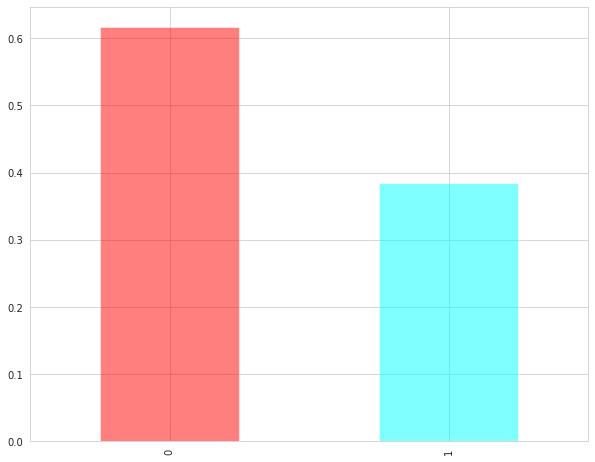

In [373]:
c = train.Survived.value_counts(normalize=True).plot(kind="bar", alpha=0.5, color = ['red', 'aqua'])
# it shows almost 40 procent survived, 60procent died

**QC** Städa ert data, hantera nullvärden, kontrollera outliers, typ av variabler (kategoriska, kontinuerliga, numeriska/labels)



a. Vilka kolumner har nullvärden?

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


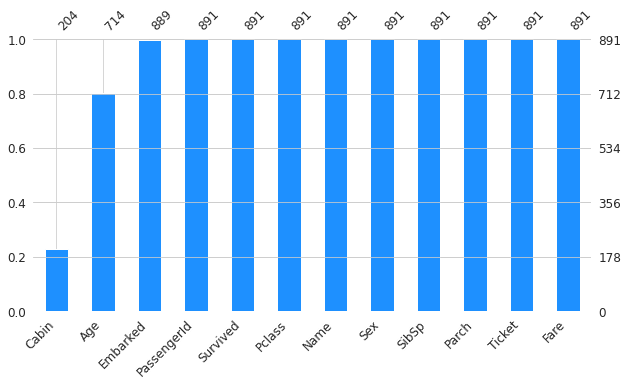

In [374]:
print(train.isna().sum())

msno.bar(train, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);


b. Hur kan dessa hanteras?

<ol>
<li type="I"> Removing rows or column  entirely
<p>We don't want to loss lot of data when we are making an analyse ( we are losing dataframe size while using drop method - this makes an other problem even if it seems we are solving missing values. If all of our columns are usefull, we will sick to removing rows (i wouldn't not using drop method if i will lose more than 5% because it is diffucult using accurate or precise analys on the dataframe). Pros is cleaning data quickly without gyessing.Cons is certain columns are missing values for many rows as i mentioned we can lose too much informatoin</br></br>
delete rows with missing values<br>
df.dropna()</p></li><br>
<li>Impute missing values</li>
<p>Instead of losing data with drop method, we can replace values woth mean, median or mode method and using fillna method for giving a value instead of droppin'. The pros to this is we don't lose full rows or colums that may be important but cons is we are adding unvertainty our column</p> 
<p>print(mean_age_df, median_age_df, mode_age_df)</br>
mean_age_df = df.Age.mean()</br>
median_age_df = df.Age.median()</br>
mode_age_df = df.Age.mode()</br>
df.Age.fillna(mean_age_df, inplace=True)</br></p></br>
</p> we should go for categorical also, titanic dataframe has cabine col we can make diffrent categories as C85,	C148	etc. We can count these column values and replace null values of max_count apperaence of value. It may not be accurate!
<p> or df.Name.fillna("unknown, inplace="True")</br></br>


<li>Mask <p> create a category for missing values. We don't lose any rows and columns. Con is we are adding another level of  uncertainty to our model based on assumption</li>
 

</ol>


<h3>c.Vilken typ av nullvärden har ni (MCAR/MAR/NMAR)?</h3>

<br>
<ol type="I">
       <li>Missing completely at random (MCAR)<br><br> <p>MCAR, there is absolutely no relationship between the data missing and any other values, observed or missing, within the dataset. In other words, those missing data points are a random subset of the data. There is no systematic approach going on that makes some data more likely to be missing than other.<br><br>
       The statistical advantage of data that are MCAR is that the analysis remains unbiased. Power may be lost in the design, but the estimated parameters are not biased by the absence of the data.<br><br>
Mean/median imputation has the assumption that the data are missing completely at random (MCAR). We solve this by replacing the NAN with the most frequent occurrence of the variables.<br><p>The Embarked Column has very few missing values and donot seem to be correlated with any other column, Hence, the missingness in Embarked column can be attributed as Missing Completely at Random.</p><br>


</p></li>
       <li>Missing not at random (MNAR) </br></br>
       <p>Systematic missing Values There is absolutely some relationship between the data missing and any other values, observed or missing, within the dataset.</br></br>

The only way to obtain an unbiased estimate of the parameters in such a case is to model the missing data.</br></br>
This kind of strategy works well if the data are not missing completely at random (MNAR).

Capture Nan values with a key value of 0 or 1, and replace the Nan values in field with any strategy like mean, median or mode.</br></br>

This way there will be a key with us for further seeing if Nan values had any effect on distribution of data.


</p></li></br></br>
       <li>Missing at random (MAR)<p></br>The missing data here is affected only by the complete (observed) variables and not by the characteristics of the missing data itself. in other words , for a data point , to be missing is not related to the missing data, but it is related to some of ( or all ) the observed data.<br><p>Age and the Cabin columns have a lot of missing values.This could be a case of MAR as we cannot directly observe the reason for missingness of data in these columns.</p>  
</li>
     </ol>



<h3>d. Vilka risker finns med ert sätt att hantera nullvärden? Varför?</h3>

jag har förklarat under - b. Hur kan dessa hanteras? 



<h3>e.Finns det outliers? Behöver de hanteras?</h3>

An outlier is an observation in data that is distant from most other observations. It is diffucult to answer sometimes outliers have more information instead of dropping i would like the handle... I found an outliers in Fare column


sb.boxplot(data=df,x=df["Fare"])
print(df["Fare"].mean())





32.2042079685746


" i make some calculation wrong - i will be back  before deadline\nq25, q50, q75 = np.percentile(df_outliers, [25,50,75])\niqr = q75 - q25\n\n#calculate the min / max limits to be considered as outlier\nmin = q25 - 1.5*(iqr)\nmax = q75 + 1.5*(iqr)\n\nprint(min, q25, q50, q75, max)\n\n[x for x in df_outliers['Age'] if x > max] \n\ndf_outliers"

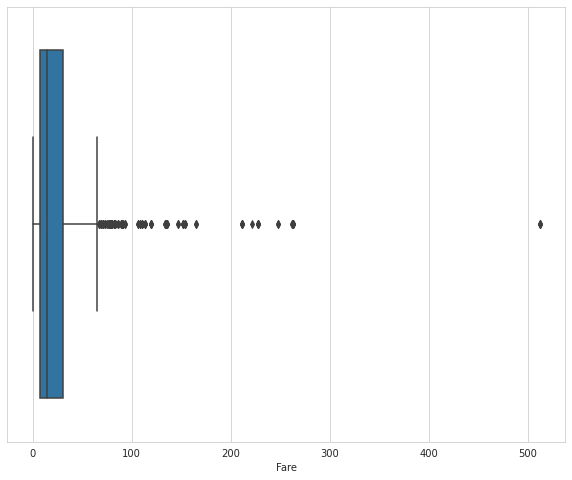

In [375]:


#Fare
sb.boxplot(data=train,x=train["Fare"])
print(train["Fare"].mean())



''' i make some calculation wrong - i will be back  before deadline
q25, q50, q75 = np.percentile(df_outliers, [25,50,75])
iqr = q75 - q25

#calculate the min / max limits to be considered as outlier
min = q25 - 1.5*(iqr)
max = q75 + 1.5*(iqr)

print(min, q25, q50, q75, max)

[x for x in df_outliers['Age'] if x > max] 

df_outliers'''



<h3>f.Vilka variabler är kategoriska och vilka är kontinuerliga?</h3>

Sex, Name, Cabin columns, Embarked are of Categorical datatype. (we can't take avarege, mean etc) 

<h2>I följande uppgifter ska ni testa två olika varianter för att ersätta null och jämföra dessa med varandra samt välja den bästa för ert syfte. </h2>
<h3>
**C** Ersätt null med medianåldern</h3>
<p><strong>**OBS!**</strong> Kom ihåg att du måste spara dina ändringar i en ny dataframe, det går inte att ta bort null två gånger ur samma dataframe. </p>


29.36158249158249


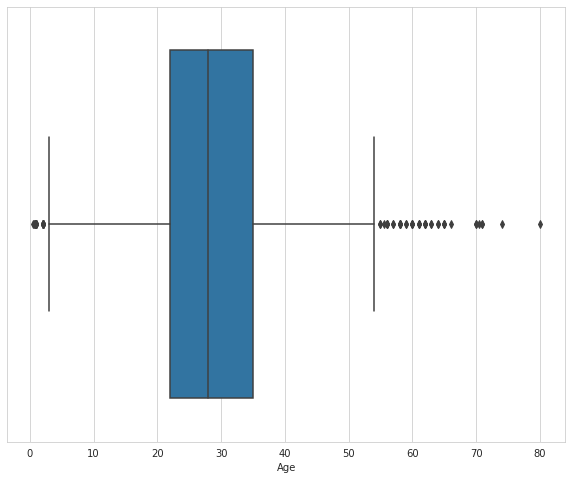

In [376]:

#Ersätt ålder med medianåldern

df_age_and_pclass = ['Age','Pclass']
titanic_passenger_fill_null_median =  train['Age'].median()

train.Age.fillna(titanic_passenger_fill_null_median,inplace=True)

sb.boxplot(data=train,x=train["Age"])
print(train["Age"].mean())




**CQ** Ersätt null med lämpliga värden baserat på andra variabler i ert dataset.
<ol >
<li> För att beräkna korrelationen mellan olika variabler i ett dataset kan vi använda pandas inbyggda `corr()`. I nedan kodcell kontrolleras samtliga variabler gentemot varandra.</li>

<li>Varför är det 1.00000 i flera rader?</li>

<li>En rule of thumb kan sägas vara att varaibler är </li><ol><li>svagt korrelerande om korrelationskoefficienten (r) <strong>är mellan 0,2-0,39</strong></li> <li>medelkorrelerade <strong>mellan 0,4-0,59</strong>,</li> <li> starkt korrelerade mellan <strong>0,6-0,79</strong>, <li> <strong>över 0,8</strong> är mycket stark </li> <li>korrelation och <strong>1 är helt beroende</strong> variabler.</li></ol>

<li>Den starkaste korrelationen finns mellan ålder och klass. Vilken typ av korrelation är det (negativ eller positiv) och hur stark?</li>

<li>I cellen under korrelationsberäkningen görs en visualisering av ålder i relation till klass. Vad säger den?</li>

<li>Ersätt nullvärdena i age baserat på vad du kom fram till i fråga 5. </li>
</ol>


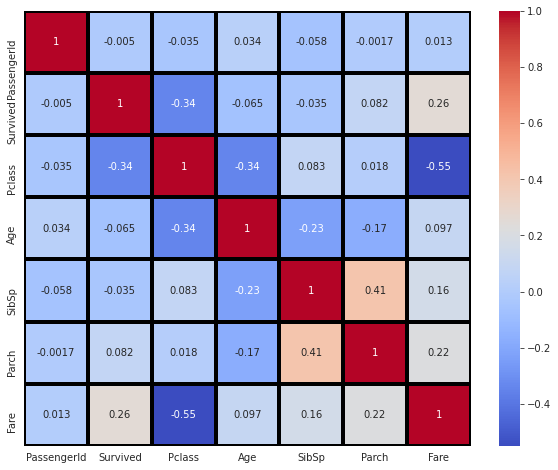

In [377]:
#1
correlation_mat = train.corr()
corr_pairs = correlation_mat.unstack()

df_corr = pd.DataFrame(train, columns=['PassengerId','Survived','Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket','Fare','Cabin','Embarked'])
sb.heatmap(correlation_mat, annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()



#2
''''the line of 1.00s going from the top left to the bottom right is the main diagonal,
 which shows that each variable always perfectly correlates with itself.'''

In [378]:
#3
sorted_pairs = corr_pairs.sort_values(kind="quicksort")

low_correlated = sorted_pairs
low_correlated = low_correlated[(low_correlated > 0.2 ) & (low_correlated <  0.39)]
print("\nlow_correlated\n", low_correlated)

moderately_correlated = sorted_pairs
moderately_correlated = moderately_correlated[(moderately_correlated > 0.4 ) & (moderately_correlated <  0.59)]
print("\nmoderately_correlated\n", moderately_correlated)

strong_correlated = sorted_pairs
moderately_correlated = strong_correlated[(strong_correlated > 0.6 ) & (moderately_correlated <  0.79)]
print("\nstrong_correlated\n", strong_correlated)


indeed_strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.8]
print("\nindeed_strong_pairs\n", indeed_strong_pairs)


completely_dependent = sorted_pairs[abs(sorted_pairs) == 1]
print("\ncompletely_dependent\n", completely_dependent)



low_correlated
 Parch     Fare        0.216225
Fare      Parch       0.216225
Survived  Fare        0.257307
Fare      Survived    0.257307
dtype: float64

moderately_correlated
 SibSp  Parch    0.414838
Parch  SibSp    0.414838
dtype: float64

strong_correlated
 Pclass       Fare          -0.549500
Fare         Pclass        -0.549500
Pclass       Age           -0.339898
Age          Pclass        -0.339898
Pclass       Survived      -0.338481
Survived     Pclass        -0.338481
SibSp        Age           -0.233296
Age          SibSp         -0.233296
             Parch         -0.172482
Parch        Age           -0.172482
Age          Survived      -0.064910
Survived     Age           -0.064910
SibSp        PassengerId   -0.057527
PassengerId  SibSp         -0.057527
SibSp        Survived      -0.035322
Survived     SibSp         -0.035322
Pclass       PassengerId   -0.035144
PassengerId  Pclass        -0.035144
Survived     PassengerId   -0.005007
PassengerId  Survived      -0.00

4 Low correlation between "Age" and "Pclass because is given a value closer to -1." 
check = sorted_pairs['Age','Pclass']
display(check)

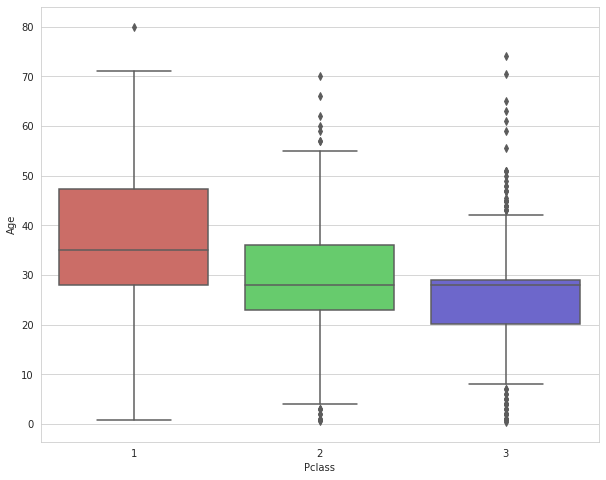

In [379]:
sb.boxplot(x='Pclass', y='Age', data=train, palette='hls')


In [380]:
#6 # jag översätt de enligt ovanför boxplot
train["Age_cat"] = 0

def impute_age(cols):
  Age = cols[1]
  Pclass = cols[0]
  if pd.isnull(Pclass):
   if Pclass == "1": 
    return 37
   elif Pclass == "2":
    return 29
   else:
    return 24
  else:
   return Age

train["Age_cat"] = train[['Age','Pclass']].apply(impute_age, axis = 1)
#print(train.isna().sum())




train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,2.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,NaN,S,3.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1.0


**Q** Vilket sätt är att föredra?
(HINT! kontrollera de vanliga mätvärdena du får med `.describe()` för ert dataset innan och efter ni ersätter nullvärden, dessa bör vara ungefär samma före som efter ex. median/medel/max/min)

In [381]:
display(train.describe())


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_cat
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208,2.308642
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429,0.836071
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,2.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,3.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,3.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,3.000000


In [382]:
display(test.describe())


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


It is more preferable to adjust the age based on class because it gives a more accurate result if a correlation exists.

**QC** Det finns en till kolumn med nullvärden 

>a.Vad är lämpligt att göra med den?
>
>b.Gör det :)

Majority of the data is missing completely, so for that the Cabin column might be ignored 

PS: There might be more advinced methods but i don't know them yet (based on code)

In [383]:
train.drop(columns=["Cabin"])


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,3.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,3.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,2.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,1.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S,3.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,1.0


**QC** Analys av varaibler

Nu har vi städat vårt dataset är det dags att förbereda det för analys. 

>a. Vilka variabler är överhuvudtaget inte intressanta för huruvida man lever eller dör? Kontrollera i vår korrelationsanalys.(OBS! Alla kolumner finns inte med eftersom det inte går att beräkna korrelation på vissa)
>
>b.När vi använder logistisk regression vill vi inte att de oberoende variablerna ska vara för korrelerade (beroende) av varandra. Det påverkar resultatet negativt. Därför tittar vi igen på vår korrelationsanalys. För att vi ska tycka korrelationen är för stark bör gränsvärdet ligga runt 0,4, rensa bland era variabler så att det inte finns några oberoende variabler som har en korrelation starkare än 0,4 till någon av de andra oberoende variablerna.
>


In [411]:
#a
#PassengerId", "Name", "Ticket"
train.drop(columns=["PassengerId", "Name", "Ticket"])

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Age_cat,harbor,Gender
0,0,3,male,22.0,1,0,7.2500,NaN,S,3.0,0,0
1,1,1,female,38.0,1,0,71.2833,C85,C,1.0,1,1
2,1,3,female,26.0,0,0,7.9250,NaN,S,3.0,0,1
3,1,1,female,35.0,1,0,53.1000,C123,S,1.0,0,1
4,0,3,male,35.0,0,0,8.0500,NaN,S,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S,2.0,0,0
887,1,1,female,19.0,0,0,30.0000,B42,S,1.0,0,1
888,0,3,female,28.0,1,2,23.4500,NaN,S,3.0,0,1
889,1,1,male,26.0,0,0,30.0000,C148,C,1.0,1,0


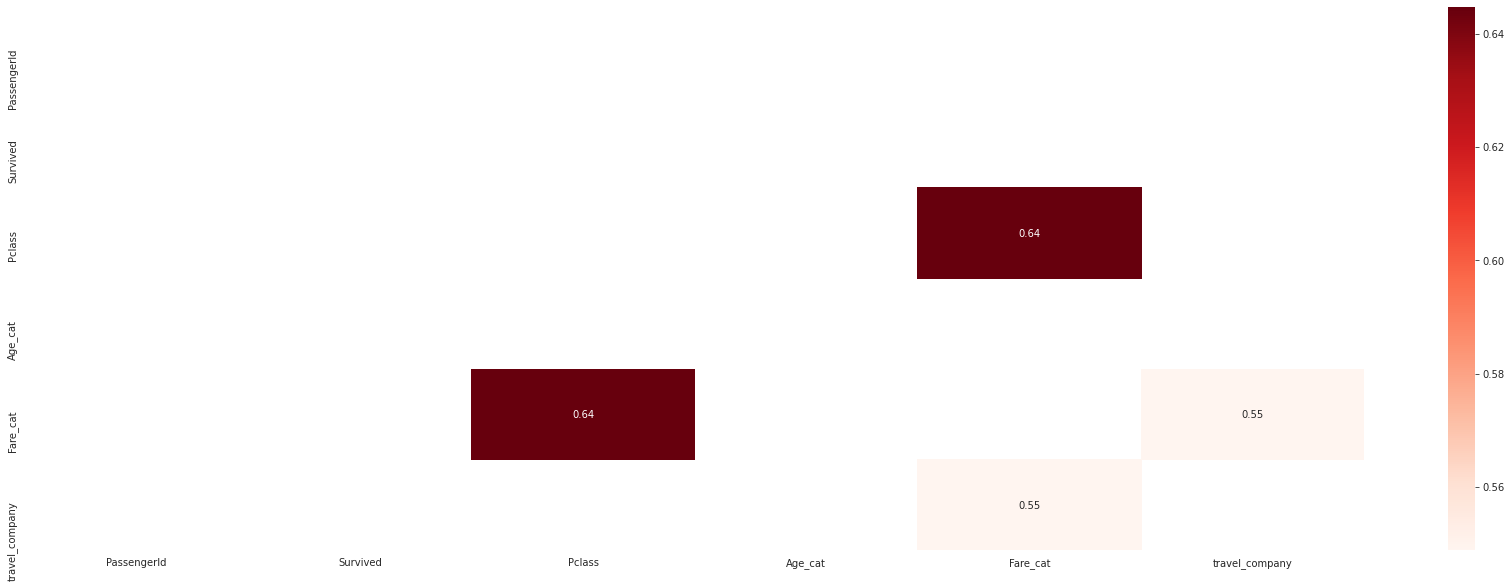

In [384]:

corr_matrix = df.corr().abs()
filter_df = corr_matrix[(corr_matrix >= .4) & (corr_matrix != 1)]
plt.figure(figsize=(30,10))
sb.heatmap(filter_df, annot=True, cmap="Reds")
plt.show()


# Create correlation matrix


# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.4)]


# Drop features 
test_after_drop = df.drop(df[to_drop], axis=1)





/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


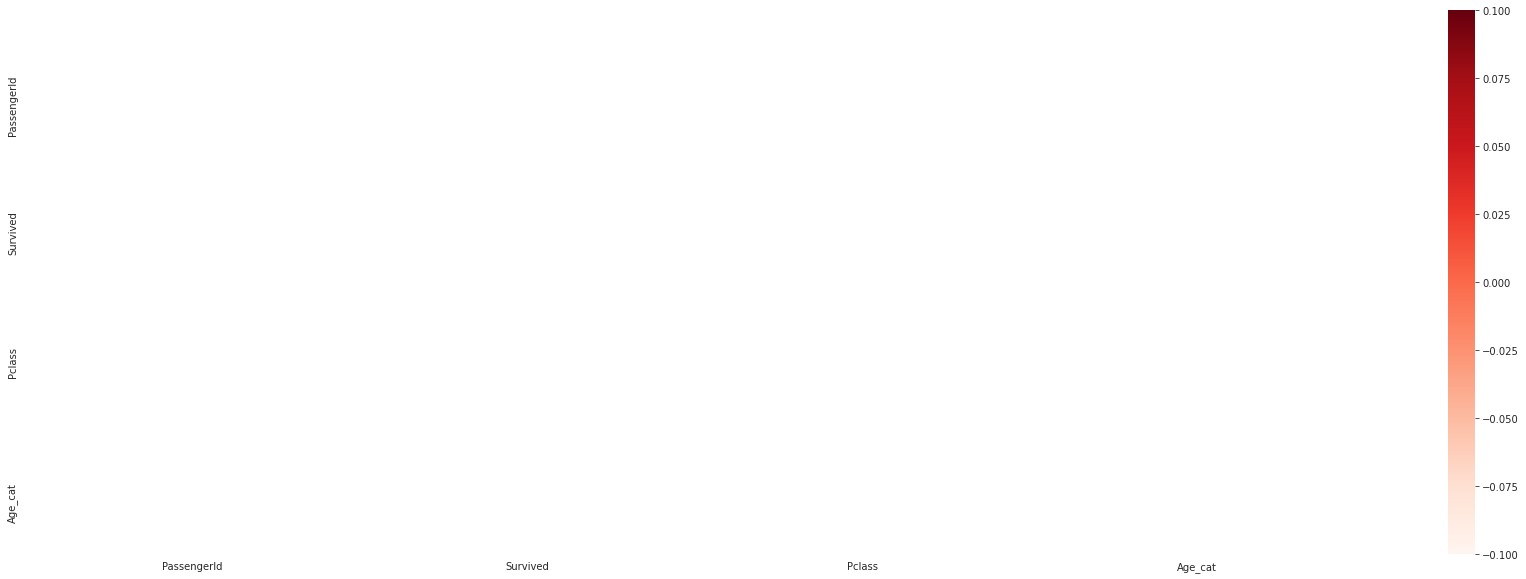

In [385]:
#check
corr_matrix = test_after_drop.corr().abs()
filter_df = corr_matrix[(corr_matrix >= .4) & (corr_matrix != 1)]
plt.figure(figsize=(30,10))
sb.heatmap(filter_df, annot=True, cmap="Reds")
plt.show()

**QC** Se till att variablerna går att applicera i vald modell.

Eftersom vi ska använda logistisk regression måste alla värden vara numeriska, vi behöver alltså ändra våra kategoriska, icke-numeriska variabler till numeriska. Detta görs lämpligen genom ungefär följande kod: `dataframe_without_kategorial_sex = pd.get_dummies(*namnet på ddataframen*, columns=['Sex'], drop_first=True)`

>
>a. Varför ersätter vi med 0 och 1 istället för 0,1,2,3?
  
>
>b. Ersätt övriga kategoriska kolumner med dummyvariabler. 
>
>

a. A single binary digit can only represent True (1) or False (0) in boolean logic, that's why

In [386]:
train["harbor"] = 0
train.loc[train['Embarked']=='S','harbor']=0
train.loc[train['Embarked']=='C','harbor']=1
train.loc[train['Embarked']=='Q','harbor']=2

train



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat,harbor
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3.0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,2.0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1.0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,NaN,S,3.0,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1.0,1


In [387]:
#9b: Gör samma sak för övriga kategoriska variabler

train["Gender"] = 0



train['Gender'] = train.Sex.map(lambda x: 1 if (x == "female" ) else 0)

#apply retunerar void som linje 14 - det var super tricky Elin / Emre K.
#train['Sex'] = train['Sex'].apply(lambda x:1 if x=='male' else 0, axis=1)
print(train.isna().sum())
display(train)



PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Age_cat          0
harbor           0
Gender           0
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat,harbor,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3.0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3.0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,2.0,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1.0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,NaN,S,3.0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1.0,1,0


**QC** Skapa modell, träna och testa (här behöver ni själva skapa ett antal kodblock för de olika deluppgifterna.)

(OBS! Se till att ni döper era variabler till X-df, X_test,y_df,y_test annars fungerar inte utvärderingskoden)

>
>a. Starta med att formatera data så att du skapar X och y där y är den beroende variabeln survival och X är samtliga beroende variabler (de som ni bestämt er för att ha kvar i ert dataset)
>
>b. Dela i träning (80%) och test (20%)
>
>c. Har vi tillräckligt med data för att kunna träna vår modell eller måste vi ta bort fler kolumner? HINT! en rule of thumb säger minst 50 rader per oberoende variabel.
>
>d.Skapa och träna modell (kod finns för starten)
>
>e.Testa modell på träningsdata
>
>f. Vad är sannolikheten för att en kvinna, ålder 34, med två barn som reser i 2:a klass med sin man överlever? 
>


In [512]:
#skpa x and y

titanic_final_data = train[['Gender','Pclass', 'SibSp','Age_cat', 'Parch','harbor',"Age"]]


X = titanic_final_data
y = train["Survived"].values


titanic_final_data


,Gender,Pclass,SibSp,Age_cat,Parch,harbor,Age
0,0,3,1,3.0,0,0,22.0
1,1,1,1,1.0,0,1,38.0
2,1,3,0,3.0,0,0,26.0
3,1,1,1,1.0,0,0,35.0
4,0,3,0,3.0,0,0,35.0
...,...,...,...,...,...,...,...
886,0,2,0,2.0,0,0,27.0
887,1,1,0,1.0,0,0,19.0
888,1,3,1,3.0,2,0,28.0
889,0,1,0,1.0,0,1,26.0


In [513]:
#a
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("tränings data har {} rader".format(len(X_train)))
print("test data har	{} rader".format(len(X_test)))



tränings data har 712 rader
test data har	179 rader


In [409]:
#C 

In [514]:
#D

#Startkod för uppgift d) skapa och träna modell

#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create logistic regression object
LogReg = LogisticRegression() 
# Train the model using the training sets and check score
LogReg.fit(X_train, y_train)
logreg_score = round(LogReg.score(X_train, y_train) * 100, 2)
#Equation coefficient and Intercept


In [515]:
#E
print('Model accuracy (a.k.a Logistic Regression Score) : ', logreg_score)
print('Coefficient: \n', LogReg.coef_)
print('Intercept: \n', LogReg.intercept_)

#Predict Output
predicted= LogReg.predict(X_test)



print(classification_report(y_test,predicted))


Model accuracy (a.k.a Logistic Regression Score) :  79.35
Coefficient: 
 [[ 2.73055693 -0.57774508 -0.32690591 -0.57774508 -0.01547225  0.17529744
  -0.03911854]]
Intercept: 
 [2.29924976]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       113
           1       0.73      0.71      0.72        66

    accuracy                           0.80       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



In [472]:
titanic_final_data.isnull().any()


Gender     False
Pclass     False
SibSp      False
Age_cat    False
Parch      False
harbor     False
dtype: bool

In [567]:
#f  kvinna, ålder 34, med två barn som reser i 2:a klass me
survived_wm_and_kidds = train[["Parch", "Survived","Age","Gender"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

w = (survived_wm_and_kidds["Age"] == 34).mean() 
s = (survived_wm_and_kidds["Gender"] ==1).mean()
p2= (survived_wm_and_kidds["Parch"]==2).mean()
sur = (survived_wm_and_kidds["Survived"]==1).mean()

print(w+s+p2+sur)



0.2857142857142857


**QC** Utvärdera modell

I nedanstående kodblock utvärderas klassificeringsmodellen på några olika sätt. 

>
>a. Vilka sätt att utvärdera en klassificeringsmodell är kodade nedan?
>
>b. För varje utvärderingsmetod som är kodad (Confusion matrix  och Classification report), vad säger de om den klassificerare ni tränat? 
>
>c. Vad är er bedömning av er klassificerare (bra/dålig) vad baserar ni detta på och varför?
>

In [334]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

NameError: ignored

ValueError: ignored

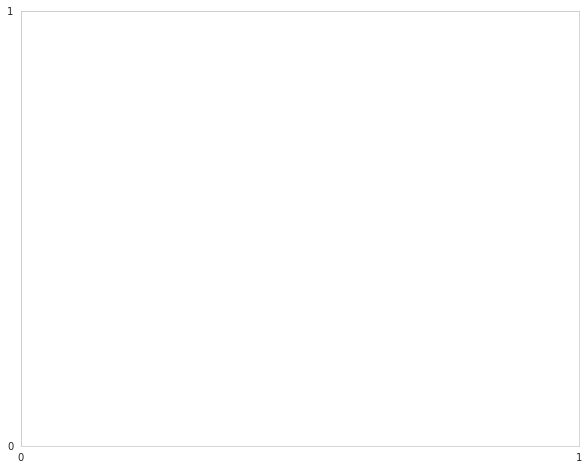

In [357]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(y_test, y_pred))

### Desicion trees för att bestämma vilka som överlever

Vi ska också testa att använda ett beslutsträd för att bestämma vilka som överlever. Koden för detta är redan given nedan. Dock ska ni besvara några frågor kring beslutsträd och jämföra resultatet mellan de två klassificerarna. 

**QC** Följande frågor ska besvaras, vissa kan kräva att ni skriver kod. Ni ska också (kortfattat) kommentera koden så att det framgår vad som görs.

>
>a. Vilka oberoende variabler (features) används i beslutsträdet för att avgöra vem som överlever?
>
>b.Hur många män respektive kvinnor överlever i prediktionen om du testar att prediktera med endast de 10 första raderna som sample (OBS! Kräver kod)
>
>c. Hur många felaktiga respektive korrekta prediktioner gör beslutsträdet i jämförelse med den logistiska regressionen?
>
>d. Vilken av algoritmerna är "bäst? för uppgiften?
>
>e. Vilka svagheter respektive styrkor har de båda modellerna i jämförelse med varandra?
>
>f.Hur har beslutsträdet "tänkt" för att komma fram till modellen?
>


In [ ]:
from graphviz import Source 
from sklearn.tree import export_graphviz 
from sklearn import tree


In [ ]:
survived_data = titantic_passengers.survived #detta motsvarar y
titantic_passengers = titantic_passengers[['sex_male', 'fare', 'age', 'sibsp']] #motsvarar X
titantic_passengers.info()


NameError: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(titantic_passengers, survived_data, test_size=0.25)
print("Our training data has {} rows".format(len(X_train)))
print("Our test data has {} rows".format(len(X_test)))

NameError: ignored

In [ ]:
classifier = DecisionTreeClassifier(max_depth=3)
classifier.fit(X_train.values, y_train.values)

In [ ]:
y_pred = classifier.predict(X_test.values)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test.values, y_pred)
confusion_matrix

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
tree_plot = Source(tree.export_graphviz(classifier, out_file=None, 
                            feature_names=X_train.columns, class_names=['Dead', 'Alive'], 
                            filled=True, rounded=True, special_characters=True))
tree_plot

*Lämna in länk till kod i colaboratory eller till GitHub repositoriet (med koden exekverad) för rättning.*